# Theoretical physics with sympy, part 2

In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
init_printing(use_unicode=True, use_latex=True)

# Motivation

![couplings](magnetic_couplings.png)

![states](magnetic_states.png)

- Magnetism is described by the interaction of magnetic moments (or "spins") on atoms
- The model of interest here is the "Heisenberg model"
- The energy of the system is described by the equation 
$$ H = J_1 \sum_{<ij>} \vec{S_1} \cdot \vec{S_2} + J_2 \sum_{<<ij>>} \vec{S_1} \cdot \vec{S_2},$$
where $J_1$ and $J_2$ are interaction strengths, $S_1$ and $S_2$ are the orientations of spins and the sums are over nearest and next-nearest neighbors in the lattice structure
- The system adopts a configuration of spins $S_i$ that minimizes the energy
- The general form of these interaction terms can be expressed by a sum over $exp(i\vec{q}\cdot\vec{r_i} + \phi_i)$, where $r_i$ is the position of the spin $i$
- Here, we are interested in a honeycomb lattice of interacting spins
- By looking at the real part of this interaction and considering an additional phase factor $\phi$ for atoms in the same unit cell, we arrive at the form of the energy as below.
- References: e.g. https://doi.org/10.1007/BF01127717

# Caveats

This notebook was developed with sympy 1.0. In newer versions (sympy 1.1), the solver gives a different solution for the phase values. I haven't figured out yet how to handle that result set.

# Setup

In [3]:
q1, q2, phi, j2 = symbols("q1 q2 phi j2", real=True)

In [4]:
from sympy.vector import CoordSysCartesian
C = CoordSysCartesian('C')

In [5]:
qv = q1*C.i + q2*C.j

e1 = cos(30*pi/180)*C.i + sin(30*pi/180)*C.j
e2 = cos(150*pi/180)*C.i + sin(150*pi/180)*C.j
e3 = cos(270*pi/180)*C.i + sin(270*pi/180)*C.j

f1 = sqrt(3)*(cos(0*pi/180)*C.i + sin(0*pi/180)*C.j)
f2 = sqrt(3)*(cos(120*pi/180)*C.i + sin(120*pi/180)*C.j)
f3 = sqrt(3)*(cos(240*pi/180)*C.i + sin(240*pi/180)*C.j)

# Write down the energy term

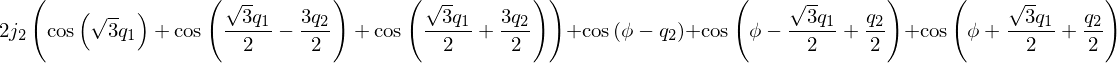

In [6]:
en = cos(e1.dot(qv) + phi) + cos(e2.dot(qv) + phi)  + cos(e3.dot(qv) + phi) \
    + 2*j2*(cos(f1.dot(qv)) + cos(f2.dot(qv)) + cos(f3.dot(qv)))
en

## Now we need to minimize this with respect to phi

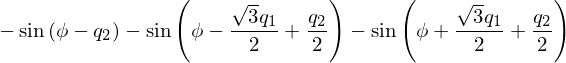

In [7]:
en.diff(phi)

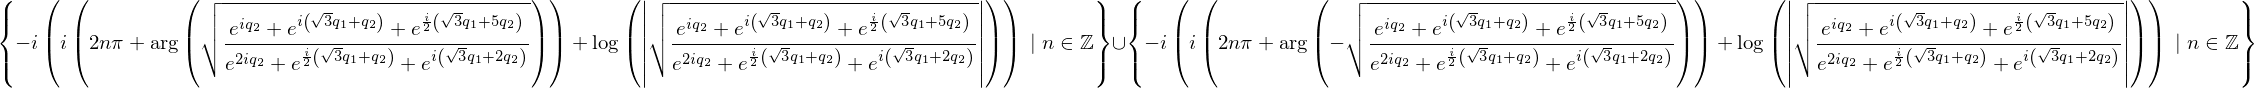

In [8]:
s = solveset(Eq(diff(en, phi)), phi); s

There are two solutions, the resulting set is a union:

In [9]:
type(s)

sympy.sets.sets.Union

Get both parts of the union:

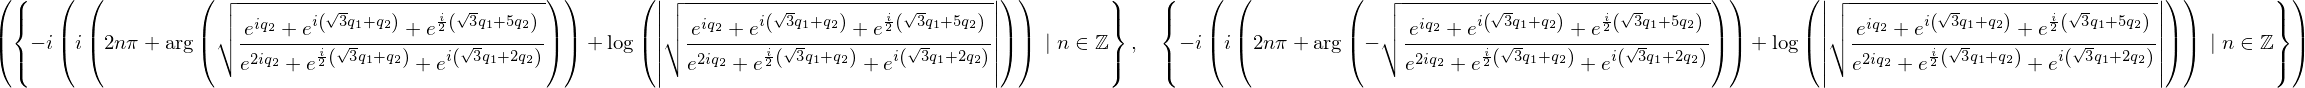

In [10]:
s.args

Each part is an ImageSet, i.e., a function applied to another set:

In [11]:
type(s.args[0])

sympy.sets.fancysets.ImageSet

The "2pi*n" part of the solutions is expected, we can take just one value of n for both. Then we get a "normal" symbolic expression:

<class 'sympy.core.mul.Mul'>


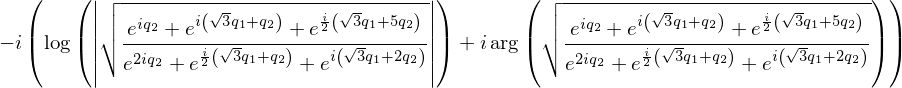

In [12]:
print(type(s.args[0].lamda(0)))
s.args[0].lamda(0)

Let's split both solutions into real and imaginary part:

In [13]:
real_parts = [solution.lamda(0).as_real_imag()[0] for solution in s.args]

In [14]:
imag_parts = [solution.lamda(0).as_real_imag()[1] for solution in s.args]

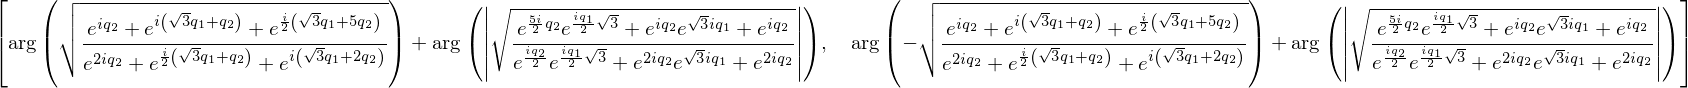

In [15]:
real_parts

The imaginary parts are zero (won't show the proof here):

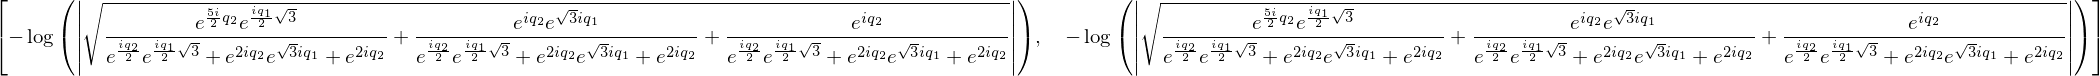

In [16]:
imag_parts

# Work with numerical solution from here on

Let's plot the real parts for both solutions. To make evaluation easy for the (q1,q2) space I'm interested in, lambdify the expressions and vectorize then using numpy.

We can "lambdify" a function for faster numerical evaluation.

In [17]:
from sympy.abc import x,y,z
lambda_function = lambdify((x, y), z*sin(x+y))
lambda_function(pi, pi/2)

In [18]:
functions_phi = [np.vectorize(
                   lambdify((q1, q2), solution, "numpy")
                 ) for solution in real_parts]

In [19]:
points = np.array([[0,     0],
                   [0,     np.pi],
                   [np.pi, 0]
                  ])
functions_phi[0](points[:,0], points[:,1])

array([  0.00000000e+00,   1.10714872e+00,   3.06902111e-17])

Set up a grid on which we evaluate everything afterwards. 

Because of the sixfold symmetry of the problem, we would only have to plot parts of the domain I'm using here, but  the plots here are nicer...

In [20]:
NUM_POINTS = 301
xx, yy = np.meshgrid(
    np.linspace(-2*np.pi, 2*np.pi, NUM_POINTS), 
    np.linspace(-2*np.pi, 2*np.pi, NUM_POINTS)
    )

In [21]:
values_phi = [func(xx, yy) for func in functions_phi]

What is the range of values for both solutions?

In [22]:
for values in values_phi:
    print(np.min(values), np.max(values))

-1.57078830856 1.57078830856
-3.14159265359 3.14159265359


The first solution is in [-pi/2, pi/2], the second solution is in [-pi, pi].

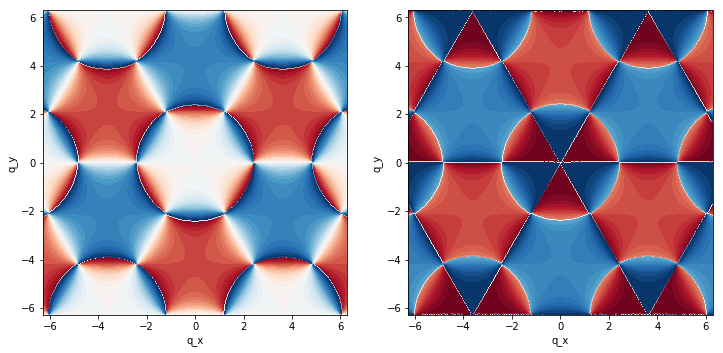

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,7))
for ax, values in zip(axs, values_phi):
    ax.contourf(xx, yy, values, 50, cmap=plt.cm.RdBu)
    ax.set_aspect(1)
    ax.set_xlabel("q_x")
    ax.set_ylabel("q_y")

We need to find out whether the solution is a minimum or maximum. 

Let's plug the minimum/maximum value for phi into the second derivative, so that we can evaluate it as a function of q1, q2.

In [24]:
second_derivative = en.diff(phi, 2)

In [25]:
second_derivative_functions = [np.vectorize(
                                 lambdify((q1, q2), second_derivative.subs(phi, phi_part), "numpy")
                                ) for phi_part in real_parts]

What's the range of values?

In [26]:
second_derivate_values = [func(xx, yy) 
                          for func 
                          in second_derivative_functions]
for values in second_derivate_values:
    print(np.min(values), np.max(values))

-3.0 3.0
-3.0 3.0


Both solutions have a positive and negative part, so in some situations correspond to minimum or maximum. A plot should show where that transition happens:

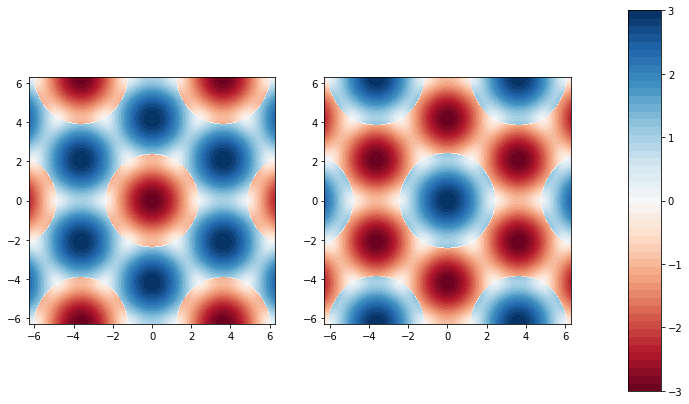

In [27]:
levels = np.linspace(
           np.min(second_derivate_values), 
           np.max(second_derivate_values), 
           50)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
for plot_ax, values in zip(axs, second_derivate_values):
    
    img = plot_ax.contourf(xx, yy, values, 
                           levels=levels, 
                           cmap=plt.cm.RdBu)
    plot_ax.set_aspect(1)
    
plt.colorbar(img, cax=axs[2], ticks=np.linspace(-3,3,7))
axs[2].set_position([0.68, 0.125, 0.03, 0.755])

We need to pick the right solution for a general value of q.

### Putting it all together

We define a function that computes the two solutions for the phase, checks which one belongs to the minimum and returns the corresponding value.
Then, we define a function that computes the energy value belonging to the minimum phase.

In [28]:
def minimum_phase(q1, q2):
    second_derivative_value = [func(q1, q2) 
                               for func 
                               in second_derivative_functions]
    maximum_idx = np.argmax(second_derivative_value)
    phi = functions_phi[maximum_idx](q1, q2)
    return phi

minimum_phase = np.vectorize(minimum_phase)

In [29]:
combined_phase = minimum_phase(xx, yy)

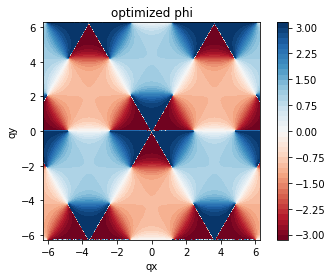

In [30]:
plt.contourf(xx, yy, combined_phase, 50, cmap=plt.cm.RdBu)
plt.gca().set_aspect(1)
plt.xlabel("qx")
plt.ylabel("qy")
plt.title("optimized phi")
plt.colorbar()

## Insert optimized $\phi$ into the energy function

We can use this function to get the energy as a function of symbolic J2:

In [31]:
@np.vectorize
def energy_of_q(q1v, q2v, j2v):
    phi_min = minimum_phase(q1v, q2v)
    e_value = N(en.subs({q1: q1v, q2: q2v, phi: phi_min, j2: j2v}))
    return e_value

In [32]:
energy_of_q(0, 0, j2)

array(6.0*j2 - 3.0, dtype=object)

### Cut along the y axis

Each line represents a different position on the qy-axis.

We can see that in the region of J2=0.2-0.4, there is a transition from which qy leads to the lowest energy.

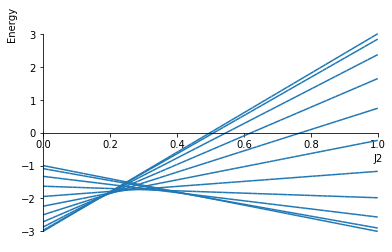

In [33]:
plot(*energy_of_q(0, np.linspace(0, 2*np.pi, 11), j2), 
     (j2, 0, 1), 
     ylabel="Energy", 
     xlabel="J2")

### Let's make a 2D plot again to see the complete domain.

At this point, lambdify is necessary - simple substitution is several orders of magnitude slower.

In [34]:
def get_j2_func(j2v):
    return np.vectorize(
        lambdify((q1, q2, phi), en.subs(j2, j2v))
    )

In [35]:
j2_values = [0.1, 1/6, 0.2, 0.4, 0.5, 0.6]
for j2_value in j2_values:
    print("Calculating J2={}".format(j2_value))
    func = get_j2_func(j2_value)
    energies = func(xx, yy, combined_phase)
    with open("lambda-energy-j2={}.np".format(j2_value), "wb") as fp:
        energies.astype(float).tofile(fp)

Calculating J2=0.1
Calculating J2=0.16666666666666666
Calculating J2=0.2
Calculating J2=0.4
Calculating J2=0.5
Calculating J2=0.6


In [36]:
def mark_minima(ax, xx, yy, energy_values, delta=1e-3):
    # Function to mark the minimum values in the energy array. 
    # Takes a certain tolerance delta, so that we see 
    # lines around the minima.
    xmins = xx[energy_values < np.min(energy_values) + delta]
    ymins = yy[energy_values < np.min(energy_values) + delta]
    ax.plot(xmins, ymins, 'r.', markersize=1.5)

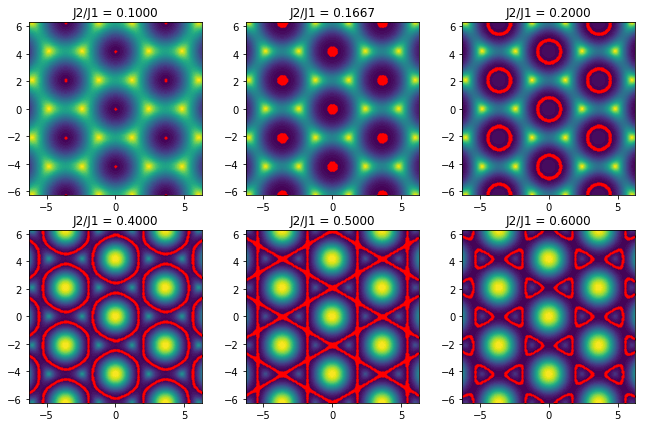

In [37]:
# read the calculated values again from disk and plot them.
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11,7))
for ax, j2v in zip(axs.ravel(), j2_values):
    filename = "lambda-energy-j2={}.np".format(j2v)
    with open(filename) as fp:
        energy_values = np.fromfile(fp).reshape((NUM_POINTS, NUM_POINTS))
        
    ax.contourf(xx, yy, energy_values,  50, cmap=plt.cm.viridis)
    mark_minima(ax, xx, yy, energy_values)
    ax.set_aspect(1)
    ax.set_title("J2/J1 = {:.4f}".format(j2v))
plt.savefig("j2.png", transparent=False)

# Conclusion

For low values of J2/J1 (< 1/6, derivation not shown here), there is a single ground state at q=0. For intermediate values 1/6 < J2/J1 < 1/2, there is almost complete rotational symmetry for a finite q. At higher J2/J1, the minima split up into six small "pockets".